Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🟦 Step 1: 加载数据
📂 共发现 8 个 CSV 文件


Reading CSV files: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]


✅ 合并后形状: (2830743, 79)

🟦 Step 2: 数据清洗

🟦 Step 3: 特征矩阵处理

🟦 Step 3.5: 分层下采样以均衡类别
各类别样本量 (英文Label/数量)：
BENIGN                    : 2273097
Bot                       : 1966
DDoS                      : 128027
DoS GoldenEye             : 10293
DoS Hulk                  : 231073
DoS Slowhttptest          : 5499
DoS slowloris             : 5796
FTP-Patator               : 7938
Heartbleed                : 11
Infiltration              : 36
PortScan                  : 158930
SSH-Patator               : 5897
Web Attack - Brute Force  : 1507
Web Attack - Sql Injection : 21
Web Attack - XSS          : 652
⚖️ 采用 min_count = 11 进行均衡抽样
🎯 下采样后数据形状: (165, 79)

🟦 Step 4: 划分训练集/测试集并保存

🧮 测试集每种类别样本数量：
BENIGN                    : 2
Bot                       : 2
DDoS                      : 2
DoS GoldenEye             : 3
DoS Hulk                  : 2
DoS Slowhttptest          : 2
DoS slowloris             : 3
FTP-Patator               : 2
Heartbleed                : 2
Infiltration              : 2
PortScan 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


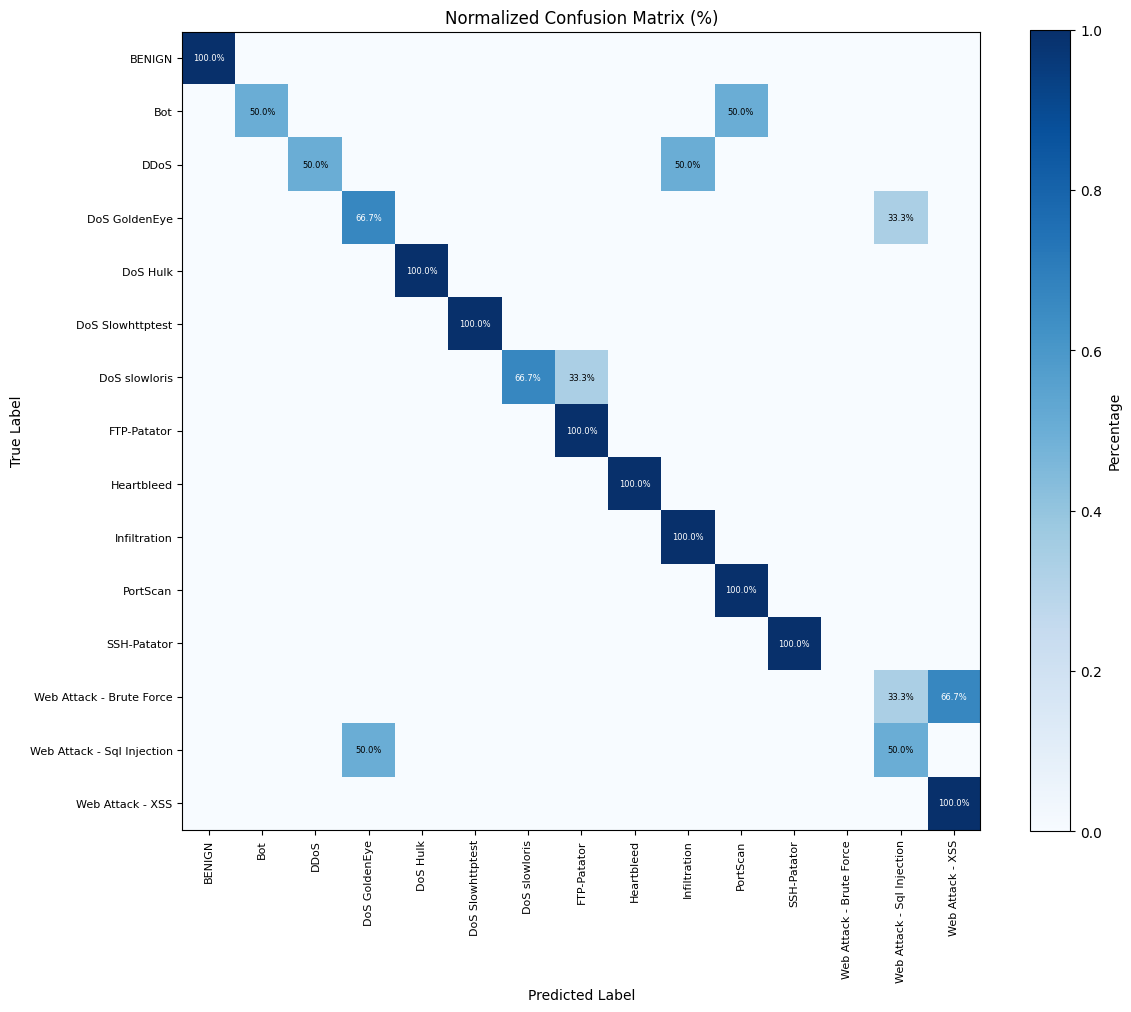


🟦 🟢 完成！全部结果、模型、数据均已保存
输出路径： 1.0_sklearn

📈 Generating PR curve, per-class metrics table & CSV exports ...


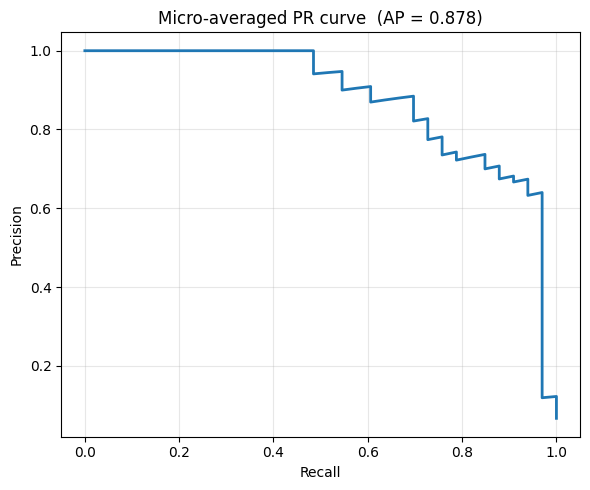

✔️  Saved micro-PR data → pr_curve_micro.csv


,recall,precision
0,1.0,0.066667
1,1.0,0.066802
2,1.0,0.066937
3,1.0,0.067073
4,1.0,0.067210


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


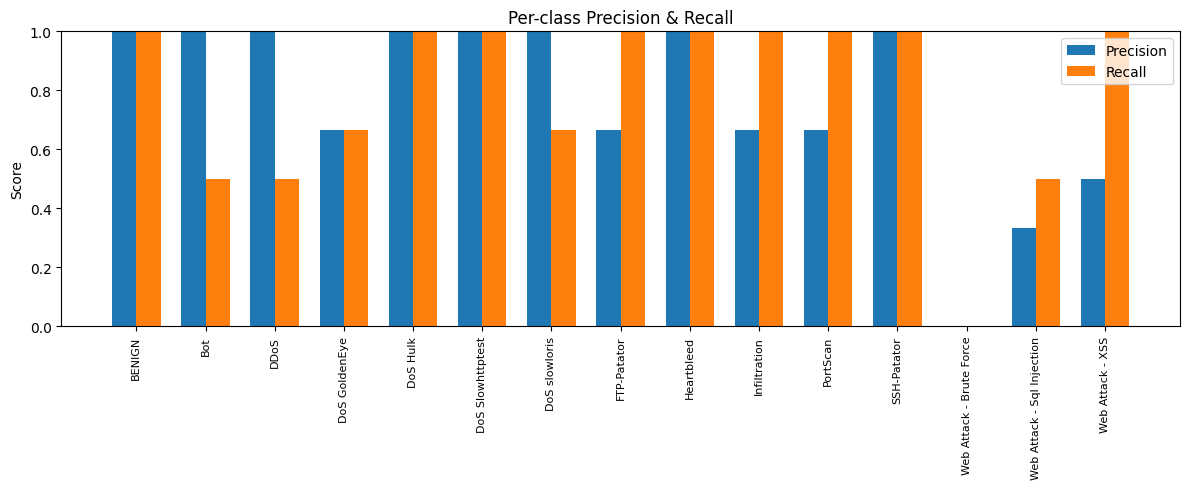

✔️  Saved per-class metrics → per_class_metrics.csv


,precision,recall,f1-score,support
BENIGN,1.0000,1.0000,1.0000,2.0
Bot,1.0000,0.5000,0.6667,2.0
DDoS,1.0000,0.5000,0.6667,2.0
DoS GoldenEye,0.6667,0.6667,0.6667,3.0
DoS Hulk,1.0000,1.0000,1.0000,2.0
DoS Slowhttptest,1.0000,1.0000,1.0000,2.0
DoS slowloris,1.0000,0.6667,0.8000,3.0
FTP-Patator,0.6667,1.0000,0.8000,2.0
Heartbleed,1.0000,1.0000,1.0000,2.0
Infiltration,0.6667,1.0000,0.8000,2.0


In [2]:
#stratified sampling
# 挂载 Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

from pathlib import Path

# 使用 pandas，不是 cuDF（适合在没有 GPU 的机器或 Colab 上运行）；
import pandas as pd
import numpy as np
import unicodedata
import joblib
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import time

# ========= 指定数据集文件位置 =========
DATA_DIR = Path("/content/drive/My Drive/Colab Notebooks/MachineLearningCVE")

OUTPUT_DIR = Path("./1.0_sklearn")
OUTPUT_DIR.mkdir(exist_ok=True)

def clean_label(label):
    if not isinstance(label, str):
        return label
    label = unicodedata.normalize("NFKD", label)
    label = label.replace("–", "-").replace("—", "-")
    return label.strip()

def section_bar(title):
    print("\n" + "="*60)
    print("🟦", title)
    print("="*60)

# 1. 加载 & 合并数据 --------------------------------------------------------
section_bar("Step 1: 加载数据")
csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"📂 共发现 {len(csv_files)} 个 CSV 文件")
dfs = [pd.read_csv(f) for f in tqdm(csv_files, desc="Reading CSV files")]
df  = pd.concat(dfs, ignore_index=True)
print(f"✅ 合并后形状: {df.shape}")

# 2. 清洗数据 ---------------------------------------------------------------
section_bar("Step 2: 数据清洗")
df.columns = df.columns.str.strip()
drop_cols = [c for c in df.columns
             if c.lower() in ["flow id", "source ip", "destination ip", "timestamp"]]
df = df.drop(columns=drop_cols, errors="ignore")

y_raw   = df.pop("Label")
# ========= 标签编码 & 分布 : 将攻击类型映射为整数编码（便于分类器使用）=========
#attack_types = y_raw.unique().to_pandas().tolist()
# 替换乱码标签
y_raw = y_raw.str.replace('Web Attack � Brute Force', 'Web Attack – Brute Force')
y_raw = y_raw.str.replace('Web Attack � XSS', 'Web Attack – XSS')
y_raw = y_raw.str.replace('Web Attack � Sql Injection', 'Web Attack – Sql Injection')

y_clean = y_raw.astype(str).apply(clean_label)
# 获取所有唯一标签
attack_types  = sorted(y_clean.unique())

# 构建了两个映射字典：attack_to_idx 和 idx_to_attack
attack_to_idx = {name: idx for idx, name in enumerate(attack_types)}
idx_to_attack = {v: k for k, v in attack_to_idx.items()}
y = y_clean.map(attack_to_idx).astype("int32")

# 3. 特征处理 ---------------------------------------------------------------
section_bar("Step 3: 特征矩阵处理")
X = df.astype("float32").fillna(0).replace([np.inf, -np.inf], 0)

# 3.5 核心亮点：分层下采样以均衡样本数------------------------------------------
# 每类抽样 min_count 条样本，形成均衡的多分类数据集
# 保证每类样本数量相同，防止模型偏向多数类；
# 采用 groupby().sample()，高效可靠；
# 随机种子设置为 42，保证实验可复现；
# 结果被打乱并重置索引
section_bar("Step 3.5: 分层下采样以均衡类别")
tmp_df = X.copy()
tmp_df["Label"] = y.values

class_counts = tmp_df["Label"].value_counts()
min_count    = class_counts.min()      # 每类保留的样本数（最小类样本数）

# === 修改①：用英文 Label 打印各类别样本量 ===
print("各类别样本量 (英文Label/数量)：")
for idx, cnt in class_counts.sort_index().items():
    print(f"{idx_to_attack[idx]:25s} : {cnt}")
print(f"⚖️ 采用 min_count = {min_count} 进行均衡抽样")

balanced_parts = []
for lbl, grp in tmp_df.groupby("Label"):
    n_keep = min(len(grp), min_count)   # 若本来更少就全保留
    balanced_parts.append(grp.sample(n=n_keep, random_state=42))

balanced_df = (pd.concat(balanced_parts)
                 .sample(frac=1.0, random_state=42)   # 打乱
                 .reset_index(drop=True))

print(f"🎯 下采样后数据形状: {balanced_df.shape}")

# 更新 X, y 供后续步骤使用
y = balanced_df.pop("Label")
X = balanced_df

# 4. 划分训练/测试集 & 保存 ---------------------------------------------------
# 按 80/20 划分训练和测试集；
# 使用 stratify=y，保证划分后类别比例不变；
# 保存数据到 OUTPUT_DIR，便于重用和分析。
section_bar("Step 4: 划分训练集/测试集并保存")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_df = X_train.copy()
train_df["Label"] = y_train.values
train_df.to_csv(OUTPUT_DIR / "train_dataset.csv", index=False)

test_df = X_test.copy()
test_df["Label"] = y_test.values
test_df.to_csv(OUTPUT_DIR / "test_dataset.csv", index=False)

with open(OUTPUT_DIR / "attack_to_idx.json", "w") as f:
    json.dump(attack_to_idx, f)

# =========== 阿米①：测试集各类别样本数量 ===========
print("\n🧮 测试集每种类别样本数量：")
test_class_counts = pd.Series(y_test.values).value_counts().sort_index()
for idx, cnt in test_class_counts.items():
    print(f"{idx_to_attack[idx]:25s} : {cnt}")

# =========== 阿米②：训练集总数（公式形式） ===========
num_classes = len(class_counts)
train_total = len(y_train)
print(f"\n📋 训练集总数: {min_count} * {num_classes} * 0.8 = {train_total}")
print("训练集的获取过程：")
print("1. 先按最稀有类别数量进行分层下采样，保证每类样本数一致；")
print("2. 再用 train_test_split 按 80/20 比例分层随机划分训练集与测试集；")
print("3. 确保各类别在训练集和测试集中的占比相同。")

# 5. 标准化 -----------------------------------------------------------
# 使用 StandardScaler 使每列特征均值为 0、方差为 1；
# 提升模型训练效率和效果；
# 保存 scaler 对象用于部署/预测时还原。
section_bar("Step 5: 标准化")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
joblib.dump(scaler, OUTPUT_DIR / "scaler.pkl")

# 6. 训练模型 ---------------------------------------------------------------
# 使用 class_weight="balanced" 自动根据样本数调整损失权重；
# 适合不均衡数据（尽管此处已平衡，仍可保留）；
# 多分类设置为 multi_class='multinomial'；
# joblib 保存模型以便部署。

section_bar("Step 6: 训练Logistic回归模型")
print("🚀 开始训练 sklearn logistic regression (auto balanced weights)...")
t0 = time.time()
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs",
    multi_class="multinomial"
)
model.fit(X_train_scaled, y_train)
joblib.dump(model, OUTPUT_DIR / "logreg_model.pkl")
print(f"训练用时: {time.time() - t0:.2f} 秒")

# 7. 测试 -------------------------------------------------------------------
section_bar("Step 7: 评估 & 混淆矩阵")
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"🎯 测试集准确率: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
classes = [idx_to_attack[i] for i in range(len(idx_to_attack))]

plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (%)")
plt.colorbar(label="Percentage")
plt.xticks(np.arange(len(classes)), classes, rotation=90, fontsize=8)
plt.yticks(np.arange(len(classes)), classes, fontsize=8)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        if val > 0.001:
            plt.text(j, i, f"{val*100:.1f}%", ha='center', va='center',
                     color="white" if val > thresh else "black", fontsize=6)
plt.tight_layout()
plt.savefig(DATA_DIR/"stratified sampling_Confusion_matrix.png", dpi=300)
plt.show()

section_bar("🟢 完成！全部结果、模型、数据均已保存")
print("输出路径：", OUTPUT_DIR)

# ========= 8. 额外可视化：PR Curve & per-class Precision/Recall =========
print("\n📈 Generating PR curve, per-class metrics table & CSV exports ...")

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    classification_report
)

# ---------- 8.1 Micro-averaged PR curve ----------
y_scores = model.predict_proba(X_test_scaled)          # (n_samples, n_classes)
y_test_bin = pd.get_dummies(y_test).values             # one-hot labels

precision, recall, pr_thresholds = precision_recall_curve(
    y_test_bin.ravel(), y_scores.ravel())              # micro-average
ap_score = average_precision_score(
    y_test_bin, y_scores, average="micro")

# ——— PR curve plot —
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Micro-averaged PR curve  (AP = {ap_score:.3f})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ——— PR curve DataFrame & CSV —
pr_df = pd.DataFrame({
    "recall":    recall,
    "precision": precision
})
pr_df.to_csv(OUTPUT_DIR / "pr_curve_micro.csv", index=False)
print("✔️  Saved micro-PR data → pr_curve_micro.csv")
display(pr_df.head())

# ---------- 8.2 Per-class metrics ----------
report_dict = classification_report(
    y_test, y_pred, target_names=classes, output_dict=True)

per_class_df = (pd.DataFrame(report_dict).T
                  .drop(["accuracy", "macro avg", "weighted avg"], errors="ignore")
                  .loc[classes]  # 保证行顺序与 classes 一致
                  [["precision", "recall", "f1-score", "support"]]
                  .round(4))

# ——— Bar chart —
x = np.arange(len(classes))
width = 0.35
plt.figure(figsize=(12, 5))
plt.bar(x - width/2, per_class_df["precision"], width, label="Precision")
plt.bar(x + width/2, per_class_df["recall"],    width, label="Recall")
plt.xticks(x, classes, rotation=90, fontsize=8)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Per-class Precision & Recall")
plt.legend()
plt.tight_layout()
plt.savefig(DATA_DIR/"stratified sampling_Per_class_metrics.png", dpi=300)
plt.show()

# ——— DataFrame & CSV —
per_class_df.to_csv(OUTPUT_DIR / "per_class_metrics.csv")
print("✔️  Saved per-class metrics → per_class_metrics.csv")
display(per_class_df)


